In [1]:
import calendar
import gc
import os
import sys
import json

import boto3
from botocore.exceptions import ClientError
from dotenv import load_dotenv
import joblib
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import pandasql as ps
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from implicit.als import AlternatingLeastSquares
import zipfile

/home/mle-user/mle_projects/mle-pr-final/env_recsys/lib/python3.10/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
/home/mle-user/mle_projects/mle-pr-final/env_recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('/home/mle-user/mle_projects/mle-pr-final/')
from src.helpers import start_mlflow_server, stop_mlflow_server, load_config, log_lightfm_model_to_mlflow, mk_model_data
from src.recsys import prepare_data_with_split, train_model, calculate_precision_at_k, save_model, load_model, grid_search_hyperparameters, prepare_data

In [7]:
arch_path = '/home/mle-user/mle_projects/mle-pr-final/data/raw'
arch_name ='archive.zip'
dest = '/home/mle-user/mle_projects/mle-pr-final/data/raw'

In [8]:
data_path = '/home/mle-user/mle_projects/mle-pr-final/data/raw'

In [9]:
if len(os.listdir(data_path))==1:
     zip_path = os.path.join(arch_path, arch_name)
     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(dest)
else:
     pass

In [10]:
os.listdir(data_path)

['category_tree.csv',
 'item_properties_part1.csv',
 'events.csv',
 'item_properties_part2.csv',
 'archive.zip']

In [11]:
category_tree = pd.read_csv(os.path.join(data_path, 'category_tree.csv'))
events = pd.read_csv(os.path.join(data_path, 'events.csv'))
item_properties_part1 = pd.read_csv(os.path.join(data_path, 'item_properties_part1.csv'))
item_properties_part2 = pd.read_csv(os.path.join(data_path, 'item_properties_part2.csv'))

In [12]:
def explore_data(df):
    """
    Исследует структуру данных: типы данных, пропущенные значения, базовые статистики.
    """
    print("===== Основная информация о данных =====")
    print(f"Размер датасета: {df.shape}")
    print("\nТипы данных:")
    print(df.dtypes)
    
    print("\nПропущенные значения:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    print("\nБазовая статистика:")
    print(df.describe())
    print(df.head(3))

In [13]:
explore_data(category_tree)

===== Основная информация о данных =====
Размер датасета: (1669, 2)

Типы данных:
categoryid      int64
parentid      float64
dtype: object

Пропущенные значения:
parentid    25
dtype: int64

Базовая статистика:
        categoryid     parentid
count  1669.000000  1644.000000
mean    849.285201   847.571168
std     490.195116   505.058485
min       0.000000     8.000000
25%     427.000000   381.000000
50%     848.000000   866.000000
75%    1273.000000  1291.000000
max    1698.000000  1698.000000
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0


In [14]:
explore_data(events)

===== Основная информация о данных =====
Размер датасета: (2756101, 5)

Типы данных:
timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

Пропущенные значения:
transactionid    2733644
dtype: int64

Базовая статистика:
          timestamp     visitorid        itemid  transactionid
count  2.756101e+06  2.756101e+06  2.756101e+06   22457.000000
mean   1.436424e+12  7.019229e+05  2.349225e+05    8826.497796
std    3.366312e+09  4.056875e+05  1.341954e+05    5098.996290
min    1.430622e+12  0.000000e+00  3.000000e+00       0.000000
25%    1.433478e+12  3.505660e+05  1.181200e+05    4411.000000
50%    1.436453e+12  7.020600e+05  2.360670e+05    8813.000000
75%    1.439225e+12  1.053437e+06  3.507150e+05   13224.000000
max    1.442545e+12  1.407579e+06  4.668670e+05   17671.000000
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214

In [15]:
explore_data(item_properties_part1)

===== Основная информация о данных =====
Размер датасета: (10999999, 4)

Типы данных:
timestamp     int64
itemid        int64
property     object
value        object
dtype: object

Пропущенные значения:
Series([], dtype: int64)

Базовая статистика:
          timestamp        itemid
count  1.100000e+07  1.100000e+07
mean   1.435158e+12  2.333851e+05
std    3.327653e+09  1.348258e+05
min    1.431227e+12  0.000000e+00
25%    1.432436e+12  1.165150e+05
50%    1.433646e+12  2.334990e+05
75%    1.437880e+12  3.501860e+05
max    1.442113e+12  4.668660e+05
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566


In [16]:
explore_data(item_properties_part2)

===== Основная информация о данных =====
Размер датасета: (9275903, 4)

Типы данных:
timestamp     int64
itemid        int64
property     object
value        object
dtype: object

Пропущенные значения:
Series([], dtype: int64)

Базовая статистика:
          timestamp        itemid
count  9.275903e+06  9.275903e+06
mean   1.435156e+12  2.333968e+05
std    3.327970e+09  1.348682e+05
min    1.431227e+12  0.000000e+00
25%    1.432436e+12  1.165175e+05
50%    1.433646e+12  2.334620e+05
75%    1.437880e+12  3.504470e+05
max    1.442113e+12  4.668660e+05
       timestamp  itemid property            value
0  1433041200000  183478      561           769062
1  1439694000000  132256      976  n26.400 1135780
2  1435460400000  420307      921  1149317 1257525


In [17]:
category_tree.categoryid.nunique(),category_tree.parentid.nunique(), category_tree.shape[0]

(1669, 362, 1669)

In [18]:
1669/362

4.610497237569061

### заметка

Количество категорий больше в 4,6 раза чем parentid, значит parentid это что то вроде группы, например как для треков был жанр.
Есть 26 категорий без parentid, присвоим им parentid равный 0, так как такого parentid в первоначальных данных нет.

In [19]:
events.head(3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


In [20]:
events.event.value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [21]:
events.event.value_counts()/events.shape[0]

event
view           0.966696
addtocart      0.025156
transaction    0.008148
Name: count, dtype: float64

In [22]:
event_gr = events.groupby('event', as_index=False).agg({'visitorid': 'nunique', 'itemid': 'nunique'})

In [23]:
event_gr

,event,visitorid,itemid
0,addtocart,37722,23903
1,transaction,11719,12025
2,view,1404179,234838


In [24]:
event_gr['visitor_share'] = event_gr['visitorid'] / events['visitorid'].nunique()
event_gr['item_share'] = event_gr['itemid'] / events['itemid'].nunique()

In [25]:
event_gr#.to_markdown()

,event,visitorid,itemid,visitor_share,item_share
0,addtocart,37722,23903,0.026799,0.101688
1,transaction,11719,12025,0.008326,0.051157
2,view,1404179,234838,0.997584,0.999051


In [108]:
art_path = '/home/mle-user/mle_projects/mle-pr-final/data/artifacts'

In [111]:
os.listdir(art_path)

['events_stats.jpg']

DataFrame:
         event  customers_count  items_count  visitor_share  item_share
0    addtocart            37722        23903       0.026799    0.101688
1  transaction            11719        12025       0.008326    0.051157
2         view          1404179       234838       0.997584    0.999051


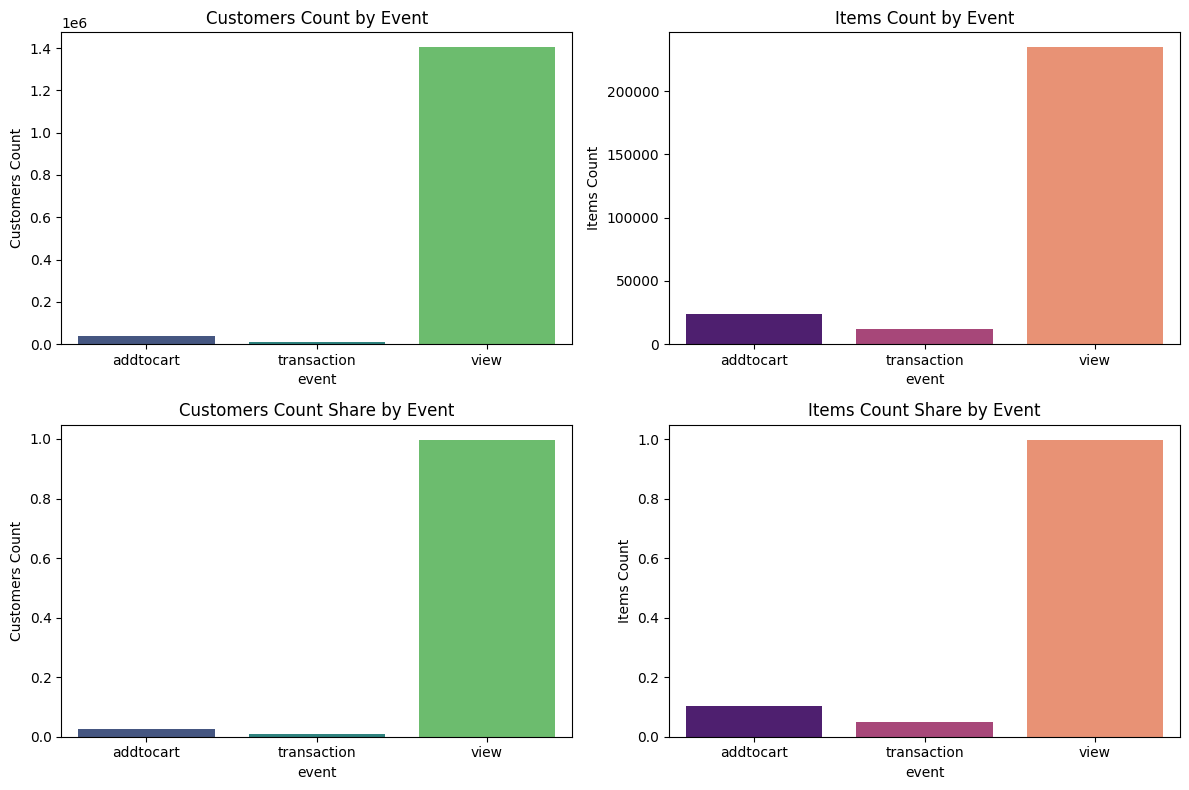

In [110]:
df = event_gr.copy()
# Переименовываем колонки
df.rename(columns={"visitorid": "customers_count", "itemid": "items_count"}, inplace=True)

# Выводим обновленный DataFrame
print("DataFrame:")
print(df)

# Визуализация данных
plt.figure(figsize=(12, 8))

# 1. Гистограмма для customers_count и items_count
plt.subplot(2, 2, 1)
sns.barplot(x="event", y="customers_count", data=df, palette="viridis")
plt.title("Customers Count by Event")
plt.ylabel("Customers Count")

plt.subplot(2, 2, 2)
sns.barplot(x="event", y="items_count", data=df, palette="magma")
plt.title("Items Count by Event")
plt.ylabel("Items Count")
plt.tight_layout()

# 1. Гистограмма для customers_count и items_count
plt.subplot(2, 2, 3)
sns.barplot(x="event", y="visitor_share", data=df, palette="viridis")
plt.title("Customers Count Share by Event")
plt.ylabel("Customers Count")

plt.subplot(2, 2, 4)
sns.barplot(x="event", y="item_share", data=df, palette="magma")
plt.title("Items Count Share by Event")
plt.ylabel("Items Count")
plt.tight_layout()

plt.savefig(os.path.join(art_path,'events_stats.jpg'))
plt.show()

### заметка
Итого у нас следующая воронка:

99% - посетителей просматривают

1% - совершает целевое действие(добавление в корзину, покупка - покупка невозможна без добавления в корзину так что считаем их вместе)

Просматривают все товары

Добовляют в корзину 10% ассортимента.

Купили 5% ассортимента.

In [27]:
events[~events.transactionid.isna()].head(3)

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0


In [28]:
events[events.transactionid.isna()].shape[0], events.shape[0]

(2733644, 2756101)

In [29]:
item_properties_part1.head(3)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


In [30]:
item_properties_part1[item_properties_part1['itemid'] == 460429]

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
2122725,1439694000000,460429,202,692224
2595719,1432436400000,460429,839,963847
6332062,1431226800000,460429,917,692224
6490575,1431226800000,460429,364,1058790
8129781,1431226800000,460429,available,0
8368211,1431226800000,460429,283,1103756 9705 963847
8566995,1433646000000,460429,283,1103756 9705 963847
8752572,1431226800000,460429,6,9705
8753668,1431226800000,460429,776,674847


In [31]:
item_properties_part2[item_properties_part2['itemid'] == 460429]

,timestamp,itemid,property,value
151187,1438484400000,460429,283,9705 963847 692224
349970,1442113200000,460429,283,9705 963847 692224
548753,1439694000000,460429,283,9705 963847 692224
563950,1431226800000,460429,888,692224
747536,1436065200000,460429,283,9705 963847 692224
788083,1435460400000,460429,764,1285872
1266667,1435460400000,460429,227,1103756 9705
1465450,1431226800000,460429,227,1103756 9705
1664233,1431831600000,460429,227,1103756 9705
1863016,1433041200000,460429,227,1103756 9705


In [32]:
item_properties_part1.property.value_counts(ascending=False)[0:10]

property
888           1629817
790            970800
available      817387
categoryid     426305
6              343207
283            323681
776            311654
678            261829
364            256340
202            242984
Name: count, dtype: int64

In [33]:
item_properties_part2.head(3)

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525


In [34]:
category_tree[category_tree['categoryid'] == 1338]

,categoryid,parentid
742,1338,1278.0


In [35]:
category_tree[category_tree['parentid'] == 1278.0]

,categoryid,parentid
170,578,1278.0
742,1338,1278.0
1134,1374,1278.0


In [36]:
category_tree.head(3)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


In [37]:
categoryid_prop1 = item_properties_part1[item_properties_part1['property'] == 'categoryid']
categoryid_prop2 = item_properties_part2[item_properties_part2['property'] == 'categoryid']
is_available1 = item_properties_part1[item_properties_part1['property'] == 'available']
is_available2 = item_properties_part1[item_properties_part1['property'] == 'available']

In [38]:
is_available = pd.concat([is_available1, is_available2])
category_prop = pd.concat([categoryid_prop1, categoryid_prop2])

### Признак доступности довара разделим на две таблицы, когда был доступен и когда нет.

In [39]:
is_available 

,timestamp,itemid,property,value
5,1436065200000,285026,available,0
15,1437274800000,186518,available,0
79,1433646000000,423682,available,0
82,1434250800000,316253,available,1
96,1437274800000,430459,available,0
...,...,...,...,...
10999926,1431831600000,350051,available,0
10999933,1433646000000,358669,available,0
10999959,1442113200000,362293,available,1
10999986,1439089200000,259404,available,1


In [40]:
is_available.groupby('value', as_index=False).agg({'itemid':'nunique','timestamp': 'count'})

,value,itemid,timestamp
0,0,219932,939226
1,1,57829,695548


In [41]:
is_available['value'] = is_available['value'].astype(int)

In [42]:
is_available_true = is_available[is_available['value'] ==1]
is_available_false = is_available[is_available['value'] ==0]

In [43]:
is_available.shape[0], is_available_true.shape[0]+ is_available_false.shape[0]

(1634774, 1634774)

In [44]:
is_available_true.columns = ['timestamp_available_true', 'itemid', 'property', 'value']
is_available_false.columns  = ['timestamp_available_false', 'itemid', 'property', 'value']

In [45]:
is_available_true['timestamp_available_true_min'] = is_available_true['timestamp_available_true']
is_available_false['timestamp_available_false_min'] = is_available_false['timestamp_available_false']

/tmp/ipykernel_2438/1894990614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_available_true['timestamp_available_true_min'] = is_available_true['timestamp_available_true']
/tmp/ipykernel_2438/1894990614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_available_false['timestamp_available_false_min'] = is_available_false['timestamp_available_false']


In [46]:
is_available_true_gr = is_available_true.groupby('itemid', as_index=False).agg({'timestamp_available_true': 'max', 'timestamp_available_true_min': 'min'})

In [47]:
is_available_false_gr = is_available_false.groupby('itemid', as_index=False).agg({'timestamp_available_false': 'max', 'timestamp_available_false_min': 'min'})

In [48]:
events

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [49]:
import psutil

print(psutil.virtual_memory())  # Информация о памяти
print(psutil.cpu_percent())  

svmem(total=33651253248, available=29207654400, percent=13.2, used=3952537600, free=26216615936, active=1597390848, inactive=4499070976, buffers=552157184, cached=2929942528, shared=1171456, slab=1183969280)
25.9


In [50]:
import gc
del item_properties_part1
del item_properties_part2
del is_available
gc.collect()

6187

In [51]:
merged = events.merge(is_available_true_gr,
    how='left',on='itemid')

In [52]:
merged.shape[0], events.shape[0]

(2756101, 2756101)

In [53]:
merged = merged.merge(is_available_false_gr,how='left', on='itemid')

In [54]:
merged 

,timestamp,visitorid,event,itemid,transactionid,timestamp_available_true,timestamp_available_true_min,timestamp_available_false,timestamp_available_false_min
0,1433221332117,257597,view,355908,NaN,1.440904e+12,1.431832e+12,NaN,NaN
1,1433224214164,992329,view,248676,NaN,1.431227e+12,1.431227e+12,NaN,NaN
2,1433221999827,111016,view,318965,NaN,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,1.440904e+12,1.431227e+12,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,NaN,NaN,1.433041e+12,1.433041e+12
2756097,1438399813142,762376,view,115946,NaN,NaN,NaN,1.431227e+12,1.431227e+12
2756098,1438397820527,1251746,view,78144,NaN,1.442113e+12,1.431227e+12,1.441508e+12,1.440904e+12
2756099,1438398530703,1184451,view,283392,NaN,NaN,NaN,NaN,NaN


In [55]:
del events
del is_available_true 
del is_available_false
gc.collect()

0

In [56]:
category_tree['categoryid'] = category_tree['categoryid'].astype(str)

In [57]:
category_prop = category_prop.merge(category_tree, how='left', left_on='value', right_on='categoryid')

In [58]:
category_prop['parentid'] = category_prop['parentid'].fillna(0).astype(int)

In [59]:
category_prop_gr = category_prop.groupby('itemid', as_index=False).parentid.unique()

In [60]:
category_prop_gr

,itemid,parentid
0,0,[293]
1,1,[113]
2,2,[1214]
3,3,[938]
4,4,[1174]
...,...,...
417048,466862,[480]
417049,466863,[788]
417050,466864,[340]
417051,466865,[1424]


In [61]:
merged = merged.merge(category_prop_gr,
    how='left', on='itemid')

In [62]:
merged = merged.fillna(0)

In [63]:
cols_to_tr = ['timestamp', 'visitorid', 'itemid', 'transactionid',
       'timestamp_available_true', 'timestamp_available_true_min',
       'timestamp_available_false', 'timestamp_available_false_min']

In [64]:
for c in cols_to_tr:
    merged[c] = merged[c].astype(int)


In [65]:
# merged.to_csv(os.path.join('/home/mle-user/mle_projects/mle-pr-final/data/processed', 'big_tab.csv.gz' ))

In [66]:
merged = pd.read_csv(os.path.join('/home/mle-user/mle_projects/mle-pr-final/data/processed', 'big_tab.csv.gz' ))

In [67]:
from datetime import datetime
def timestamp2date(timestamp):
    """Converts timestamp into a date."""
    date = datetime.fromtimestamp(timestamp / 1000)
    return date.date()

In [68]:
merged.head(1)

,Unnamed: 0,timestamp,visitorid,event,itemid,transactionid,timestamp_available_true,timestamp_available_true_min,timestamp_available_false,timestamp_available_false_min,parentid
0,0,1433221332117,257597,view,355908,0,1440903600000,1431831600000,0,0,[805]


In [69]:
merged['trans_data'] = merged['timestamp'].apply(timestamp2date)

In [70]:
merged['timestamp_available_true_data'] = merged['timestamp_available_true'].apply(timestamp2date)
merged['timestamp_available_true_min_data'] = merged['timestamp_available_true_min'].apply(timestamp2date)
merged['timestamp_available_false_data'] = merged['timestamp_available_false'].apply(timestamp2date)
merged['timestamp_available_false_min_data'] = merged['timestamp_available_false_min'].apply(timestamp2date)

In [71]:
merged['is_av_y'] = merged['timestamp_available_true_data'].apply(lambda x: x.year)

In [72]:
merged.groupby('event', as_index=0)['is_av_y'].value_counts()

,event,is_av_y,count
0,addtocart,2015,43143
1,addtocart,1970,26189
2,transaction,2015,13693
3,transaction,1970,8764
4,view,1970,1629548
5,view,2015,1034764


### Заметка
судя по тому что большая часть транзакций и добавлений в корзину имеет признак о доступности товара, но все же много пропущенных значений и в рамках задачи я не буду терять время на эти признаки.

In [73]:
merged.head(1)

,Unnamed: 0,timestamp,visitorid,event,itemid,transactionid,timestamp_available_true,timestamp_available_true_min,timestamp_available_false,timestamp_available_false_min,parentid,trans_data,timestamp_available_true_data,timestamp_available_true_min_data,timestamp_available_false_data,timestamp_available_false_min_data,is_av_y
0,0,1433221332117,257597,view,355908,0,1440903600000,1431831600000,0,0,[805],2015-06-02,2015-08-30,2015-05-17,1970-01-01,1970-01-01,2015


In [74]:
merged['parentid']=merged['parentid'].astype(str)

In [75]:
category_events = merged.groupby(['event','parentid'], as_index=0).agg({'itemid':'nunique','timestamp': 'count'})

In [103]:
category_events[category_events['event']=="view"].sort_values('timestamp', ascending=0)[0:3] 

,event,parentid,itemid,timestamp
779,view,0,49814,254277
1189,view,[1606],3501,101425
1470,view,[955],3128,94464


In [101]:
category_events[category_events['event']=='addtocart'].sort_values('timestamp', ascending=0)[0:3]

,event,parentid,itemid,timestamp
331,addtocart,[561],562,2645
418,addtocart,[955],499,2250
191,addtocart,[1426],482,2200


In [102]:
category_events[category_events['event']=='transaction'].sort_values('timestamp', ascending=0)[0:3] 

,event,parentid,itemid,timestamp
696,transaction,[561],331,880
773,transaction,[955],275,667
499,transaction,[1095],223,556


In [79]:
category_events['event'].unique()

array(['addtocart', 'transaction', 'view'], dtype=object)

In [80]:
byers = merged[merged['event'] == 'transaction'].visitorid.unique()
len(byers)

11719

In [81]:
merged[(merged['event'] == 'addtocart') & (merged['visitorid'].isin(byers))].visitorid.nunique()

10576

In [82]:
merged[(merged['event'] == 'addtocart')].visitorid.nunique()

37722

In [83]:
addcart_topcategory = category_events[category_events['event']=='addtocart'].sort_values('timestamp', ascending=0)

In [90]:
top100ctegory = addcart_topcategory.head(100) 

In [92]:
top100ctegory.head(1)

,event,parentid,itemid,timestamp
331,addtocart,[561],562,2645


In [93]:
top100ctegory.rename(columns={"parentid": "category", "itemid": "items_cnt", "timestamp": "customers_cnt"}, inplace=True)

/tmp/ipykernel_2438/2063674206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100ctegory.rename(columns={"parentid": "category", "itemid": "items_cnt", "timestamp": "customers_cnt"}, inplace=True)


In [95]:
top_n = []
for i in range(1,101):
    top_n.append(i)

In [97]:
top100ctegory["top_n"] = top_n

/tmp/ipykernel_2438/3164872737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100ctegory["top_n"] = top_n


In [99]:
pocdata_p = '/home/mle-user/mle_projects/mle-pr-final/data/processed'

In [100]:
top100ctegory.to_csv(os.path.join(pocdata_p,'top100ctegory.csv.gz'))

### заметка
Визуально ТОП товаров для различных взаимодействий отличается, что логично исходя из статистик выше просмотр 99% добавили в корзину 10% и купили 5%.
Поскольку задача разрабатываемой рекомендательной системы увеличить целевое действие - "добавление товара в корзину", то в дальнейшем я буду использовать топ 100 категорий товаров для добавления в корзину.

In [84]:
merged.to_csv(os.path.join('/home/mle-user/mle_projects/mle-pr-final/data/processed', 'big_tab_time.csv.gz' ))

### EDA Sammary
### **Саммари проведенного EDA**

#### **1. Общая информация о данных**
Проект направлен на разработку рекомендательной системы для онлайн-магазина с целью увеличения количества клиентов, добавляющих товары в корзину. В рамках анализа были исследованы следующие датасеты:

1. **`category_tree`**:
   - Содержит информацию о категориях товаров и их иерархии (родительские категории `parentid`).
   - Размер: 1669 строк, 2 столбца.
   - Пропущенные значения: 25 записей в столбце `parentid`.
   - Анализ показал, что `parentid` можно рассматривать как группу или "родительскую категорию", аналогично жанрам у треков. Для 26 категорий без `parentid` было предложено присвоить значение `0`, чтобы упростить анализ.

2. **`events`**:
   - Хранит данные о взаимодействии пользователей (`visitorid`) с товарами (`itemid`) через различные события (`event`): просмотр (`view`), добавление в корзину (`addtocart`) и покупка (`transaction`).
   - Размер: 2,756,101 строк, 5 столбцов.
   - Пропущенные значения: в столбце `transactionid` отсутствуют данные для большинства событий (2,733,644 записи из 2,756,101).
   - Базовая статистика показала, что:
     - 99% пользователей только просматривают товары.
     - 1% пользователей совершают целевые действия (добавление в корзину или покупка).
     - Товары, которые добавляются в корзину, составляют ~10% ассортимента, а покупаются ~5%.

3. **`item_properties_part1` и `item_properties_part2`**:
   - Содержат дополнительные свойства товаров (`property` и `value`) с временной меткой (`timestamp`).
   - Размер: 10,999,999 строк, 4 столбца.
   - Пропущенных значений нет.
   - Эти данные могут быть полезны для анализа характеристик товаров, но в рамках задачи они не используются напрямую.

---

#### **2. Ключевые выводы по данным**

1. **Воронка конверсии**:
   - Просмотр: 99% пользователей.
   - Добавление в корзину: ~1% пользователей.
   - Покупка: ~0.5% пользователей.
   - Это указывает на низкую конверсию в целевые действия, что является основной проблемой для решения.

2. **Товарная структура**:
   - Товары распределены по категориям, которые объединены в группы (`parentid`).
   - Некоторые категории не имеют родительских групп (`parentid` = NaN). Для удобства анализа им было присвоено значение `0`.

3. **Распределение действий**:
   - Большинство взаимодействий связано с просмотром товаров.
   - Добавление в корзину и покупки происходят значительно реже, что подтверждает необходимость повышения эффективности рекомендаций.

4. **ТОП-товары**:
   - ТОП товаров для различных типов взаимодействий отличается, что логично, учитывая различную природу действий (просмотр, добавление в корзину, покупка).
   - Для решения задачи будут использоваться ТОП-100 категорий товаров, наиболее популярных для добавления в корзину.

5. **Доступность товаров**:
   - Большая часть транзакций (добавлений в корзину и покупок) связана с доступными товарами, однако в данных есть много пропусков по этому признаку. Учитывая задачу проекта, этот признак был исключен из анализа.

---

#### **3. Рекомендации для дальнейшей работы**

1. **Фокус на добавление в корзину**:
   - Основная цель — увеличить количество добавлений товаров в корзину. Для этого следует сосредоточиться на:
     - Аналитике ТОП-100 категорий товаров, которые чаще всего добавляются в корзину.
     - Разработке рекомендаций, которые будут предлагать релевантные товары из этих категорий.

2. **Использование категорий и групп**:
   - Иерархическая структура категорий (`categoryid` и `parentid`) может быть полезна для создания более точных рекомендаций. Например, можно рекомендовать товары из одной группы (`parentid`) или связанные категории.

3. **Учет поведенческих данных**:
   - Данные о взаимодействиях (`events`) содержат ценные сведения о поведении пользователей. Это можно использовать для:
     - Оценки популярности товаров.
     - Выявления паттернов взаимодействий (например, какие товары чаще просматриваются перед добавлением в корзину).

4. **Пропущенные значения**:
   - Пропуски в данных (например, в `transactionid`) требуют внимания в случае необходимости анализа покупок. Однако для текущей задачи они не критичны.

5. **Дополнительные данные**:
   - Данные из `item_properties_part1` и `item_properties_part2` могут быть полезны для анализа характеристик товаров (например, сезонности, цен, доступности). Однако их использование требует дополнительного исследования.

---

#### **4. Заключение**
EDA позволил выявить ключевые особенности данных и определить направления для дальнейшей работы:
- Фокус на категориях товаров, которые чаще добавляются в корзину.
- Использование иерархической структуры категорий для улучшения рекомендаций.
- Учет поведенческих данных для анализа пользовательских паттернов.

Эти выводы помогут разработать эффективную рекомендательную систему, которая повысит конверсию в добавление товаров в корзину.

### Logging summary with MLFlow

In [20]:
config = load_config('/home/mle-user/mle_projects/mle-pr-final/config/config.json')
art_path = config["art_path"]
env_path = config["env_path"]

In [5]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

In [14]:
os.listdir('/home/mle-user/mle_projects/mle-pr-final/infrastructure')

['run_mlflow_server.sh', 'run_recs_service.sh', 'mlflow_server.pid', '.env']

In [21]:
load_dotenv(env_path)

True

In [22]:
print(os.getenv("AWS_ACCESS_KEY_ID"))

YCAJE3Nlz8iDILW5VTYM1ihQB


In [7]:
start_mlflow_server('/home/mle-user/mle_projects/mle-pr-final/config/config.json')

Перешли в директорию: /home/mle-user/mle_projects/mle-pr-final/infrastructure
Сервер запущен в фоновом режиме. PID: 2231
PID сервера сохранен в файл: /home/mle-user/mle_projects/mle-pr-final/infrastructure/mlflow_server.pid


In [23]:

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(config['experiment_name'])
if not experiment:
    experiment_id = mlflow.create_experiment(config['experiment_name'])
else:
    experiment_id = experiment.experiment_id

RUN_NAME = "eda"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id

    mlflow.log_artifact(os.path.join(art_path,'eda_summary.md'), "eda")
    mlflow.log_artifact(os.path.join(art_path, 'events_stats.jpg'), "eda")


In [24]:
stop_mlflow_server('/home/mle-user/mle_projects/mle-pr-final/config/config.json')

Найден PID сервера: 2231
Сервер с PID 2231 успешно остановлен.
Файл с PID удален: /home/mle-user/mle_projects/mle-pr-final/infrastructure/mlflow_server.pid


# Build recs
Feature engineering

In [3]:
merged = pd.read_csv(os.path.join('/home/mle-user/mle_projects/mle-pr-final/data/processed', 'big_tab.csv.gz' ), index_col=0)


In [4]:
merged[(merged['event'] == 'addtocart')].visitorid.nunique()

37722

In [5]:
byers = merged[merged['event'] == 'transaction'].visitorid.unique()
len(byers)


11719

In [6]:
merged[(merged['event'] == 'addtocart') & (merged['visitorid'].isin(byers))].visitorid.nunique()

10576

### Заметка
всего 37722 уникальных пользователя добавивших товар в корзину
Из них 10576 - купили
А купили товар 11719 можно предположить что они тоже прошли через прошли через добавление в корзину но точно это неизвестно.


merged

In [7]:
config = load_config('/home/mle-user/mle_projects/mle-pr-final/config/config.json')
raw_data_path = config['raw_data_path']
event_df  = pd.read_csv(os.path.join(raw_data_path, 'events.csv'))
# model_df = event_df[event_df['event'] != 'transaction'].copy()
model_df = merged[merged['event'] != 'transaction'].copy()

In [8]:
model_df['rating'] = np.where(model_df['event'] == 'addtocart', 5,1)

In [9]:
model_df['rating'].value_counts()

rating
1    2664312
5      69332
Name: count, dtype: int64

In [10]:
target_users = merged[merged['event'] == 'addtocart'].visitorid.unique()

In [11]:
len(target_users)

37722

### Разобьем на train test
Для обучения модели возмем пользователей которые просматривали от 10 товаров.

трейн тест разобъем в пропорции 80/20

In [12]:
filter_users = merged.groupby('visitorid', as_index=0)['itemid'].nunique()

In [13]:
train_users = filter_users[(filter_users['itemid']>10)].visitorid.unique()

In [14]:
filter_users[filter_users.visitorid.isin(train_users)].head(10)#.to_markdown()

,visitorid,itemid
155,155,13
172,172,22
351,351,14
549,549,17
627,627,12
648,648,12
1014,1014,24
1136,1136,11
1581,1581,11
1879,1879,117


In [15]:
cond_tr = (model_df['visitorid'].isin(train_users))

In [16]:
train_df = model_df[cond_tr][['visitorid', 'itemid', 'rating']]

In [17]:
train_df = train_df.groupby(['visitorid','itemid'], as_index=0).rating.max()

In [18]:
train_df.rating.value_counts()

rating
1    205554
5     18473
Name: count, dtype: int64

In [19]:
train_interactions, test_interactions, dataset = prepare_data_with_split(train_df)

In [18]:
baseline_model = train_model(train_interactions, epochs=30)

In [22]:
k=5
precision = precision_at_k(
        model=baseline_model,
        test_interactions=test_interactions,
        train_interactions=train_interactions,
        k=k,
        num_threads=4
    ).mean()
    
print(f"baseline_model Precision@{k}: {precision:.4f}")

baseline_model Precision@5: 0.0107


In [25]:
params_n300 = {
        'loss': 'warp',  # Функция потерь (например, 'warp', 'bpr', 'logistic')
        'learning_rate': 0.01,
        'item_alpha': 0.0,
        'user_alpha': 0.0,
        'no_components': 300  # Размерность эмбеддингов
    }

In [26]:
model_n300 = train_model(train_interactions, epochs=300, model_params=params_n300)

In [27]:
k=5
precision_n300 = precision_at_k(
        model=model_n300,
        test_interactions=test_interactions,
        train_interactions=train_interactions,
        k=k,
        num_threads=4
    ).mean()
    
print(f"model_n300 Precision@{k}: {precision_n300:.4f}")

model_n300 Precision@5: 0.0405


In [28]:
config = load_config('/home/mle-user/mle_projects/mle-pr-final/config/config.json')

In [29]:
model_path = config['model_path']
model_path

'/home/mle-user/mle_projects/mle-pr-final/data/models'

In [34]:
save_model(baseline_model, os.path.join(model_path, "baseline_model.pkl"))

Модель успешно сохранена в файл: /home/mle-user/mle_projects/mle-pr-final/data/models/baseline_model.pkl


In [35]:
save_model(model_n300, os.path.join(model_path, "model_n300.pkl"))

Модель успешно сохранена в файл: /home/mle-user/mle_projects/mle-pr-final/data/models/model_n300.pkl


In [36]:
os.listdir(model_path)

['model_n300.pkl', 'baseline_model.pkl']

### grid search hyperparameters

In [3]:
conf_path = '/home/mle-user/mle_projects/mle-pr-final/config/config.json'
light_df = mk_model_data(conf_path)

In [4]:
interactions, weights, user_id_map, item_id_map = prepare_data(light_df)

In [5]:
param_grid = {
        'loss': ['warp', 'bpr'],
        'learning_rate': [0.01, 0.05],
        'no_components': [10, 50, 150],
        'epochs': [30, 50, 101]
    }

In [10]:
params = {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 10, 'epochs': 30}

In [14]:
 pd.DataFrame([params])

,loss,learning_rate,no_components,epochs
0,warp,0.01,10,30


In [13]:
params_df = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value']).T
params_df 

,0,1,2,3
Parameter,loss,learning_rate,no_components,epochs
Value,warp,0.01,10,30


In [6]:
best_params, best_score = grid_search_hyperparameters(light_df, param_grid, k=5)

Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 10, 'epochs': 30}
Precision@5: 0.0094
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 10, 'epochs': 50}
Precision@5: 0.0107
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 10, 'epochs': 101}
Precision@5: 0.0109
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 50, 'epochs': 30}
Precision@5: 0.0120
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 50, 'epochs': 50}
Precision@5: 0.0138
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 50, 'epochs': 101}
Precision@5: 0.0197
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 150, 'epochs': 30}
Precision@5: 0.0140
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_components': 150, 'epochs': 50}
Precision@5: 0.0175
Тестируем параметры: {'loss': 'warp', 'learning_rate': 0.01, 'no_com